<a href="https://colab.research.google.com/github/palinkapro/FM-detector/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports
import os 
import numpy as np
import xml.etree.ElementTree as ET
from xml.dom.minidom import parse
import shutil
import random
from random import shuffle
from glob import glob
from IPython.display import Image

In [ ]:
# preprocessing dataset (code taken from dataset kaggle notebook)

!mkdir -p train_data/images/train
!mkdir -p train_data/images/val
!mkdir -p train_data/labels/train
!mkdir -p train_data/labels/val

path = "../input/face-mask-detection/annotations"
classes = {"with_mask":0,"without_mask":1,"mask_weared_incorrect":2}

for annotations in os.listdir(path):
    
    
    dom = parse(os.path.join(path,annotations))
    root = dom.documentElement
    filename = ".txt".join(root.getElementsByTagName("filename")[0].childNodes[0].data.split(".png"))
    
    image_width = root.getElementsByTagName("width")[0].childNodes[0].data
    image_height = root.getElementsByTagName("height")[0].childNodes[0].data
    with open("./train_data/labels/train/"+filename,"w") as r:
        
        for items in root.getElementsByTagName("object") :
            
            name = items.getElementsByTagName("name")[0].childNodes[0].data
            xmin = items.getElementsByTagName("xmin")[0].childNodes[0].data
            ymin = items.getElementsByTagName("ymin")[0].childNodes[0].data
            xmax = items.getElementsByTagName("xmax")[0].childNodes[0].data
            ymax = items.getElementsByTagName("ymax")[0].childNodes[0].data
            x_center_norm = ((int(xmin)+int(xmax)) / 2 ) / int(image_width)
            y_center_norm = ((int(ymin)+int(ymax))/2) / int(image_height)
            width_norm = ((int(xmax)-int(xmin))/int(image_width))
            height_norm = ((int(ymax)-int(ymin))/int(image_height))
            
            r.write(str(classes[name]))
            r.write(" ")
            r.write(str(x_center_norm))
            r.write(" ")
            r.write(str(y_center_norm))
            r.write(" ")
            r.write(str(width_norm))
            r.write(" ")
            r.write(str(height_norm))
            r.write("\n")
            
path = "../input/face-mask-detection/images"
for images in os.listdir(path):
    image_path = os.path.join(path,images)
    shutil.copy(image_path,"./train_data/images/train/"+images)

random.seed(42)
files = glob("./train_data/images/train/*.png")
shuffle(files)
txt_train_path = "./train_data/labels/train/"
img_train_path = "./train_data/images/train/"
txt_val_path = "./train_data/labels/val/"
img_val_path = "./train_data/images/val/"
for i in files[:120]:
    filename = i.split("/")[-1]
    shutil.move(txt_train_path+filename.replace(".png",".txt"),txt_val_path+filename.replace(".png",".txt"))
    shutil.move(img_train_path+filename,img_val_path+filename)

!echo "train: /kaggle/working/train_data/images/train/" > /kaggle/working/data.yaml
!echo "val:   /kaggle/working/train_data/images/val/" >> /kaggle/working/data.yaml
!echo "nc : 3" >> /kaggle/working/data.yaml
!echo "names: ['mask', 'no_mask', 'mask_incorrect']" >> /kaggle/working/data.yaml

!cat /kaggle/working/data.yaml

train: /kaggle/working/train_data/images/train/
val:   /kaggle/working/train_data/images/val/
nc : 3
names: ['mask', 'no_mask', 'mask_incorrect']


In [ ]:
# model framework
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 7587, done.
remote: Counting objects: 100% (307/307), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 7587 (delta 191), reused 243 (delta 175), pack-reused 7280
Receiving objects: 100% (7587/7587), 9.04 MiB | 19.12 MiB/s, done.
Resolving deltas: 100% (5207/5207), done.
/kaggle/working/yolov5


In [ ]:
#analytics and logging
import wandb

# 1. Start a new run
wandb.init(project='face_mask_detection', entity='palinkapro')

# 2. Save model inputs and hyperparameters
config = wandb.config
config.learning_rate = 0.01

# 3. Log gradients and model parameters
#wandb.watch(model)
#for batch_idx, (data, target) in enumerate(train_loader):
#  ...
#  if batch_idx % args.log_interval == 0:
#    # 4. Log metrics to visualize performance
#    wandb.log({"loss": loss})
  

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
#training
!python train.py --img 320 --batch 32 --epochs 200 --data /kaggle/working/data.yaml --weights yolov5s.pt --cache 

train: weights=yolov5s.pt, cfg=, data=/kaggle/working/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=200, batch_size=32, img_size=[320], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket=, cache_images=True, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
2021-06-27 09:42:57.972965: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
wandb: Currently logged in as: palinkapro (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-06-27 09:43:00.979289: I te

In [ ]:
#save model
!cp runs/train/exp/weights/best.pt weights

In [ ]:
#random images
!mkdir random_data
%cd random_data
!wget https://www.globaltimes.cn/Portals/0/attachment/2020/2020-03-09/b200de50-cf2a-4804-ba5f-4e4dc80de043.jpeg
!wget https://www.ctvnews.ca/polopoly_fs/1.4986740.1592334933!/httpImage/image.jpg_gen/derivatives/landscape_960/image.jpg    
    

/kaggle/working/yolov5/random_data
--2021-06-27 10:33:54--  https://www.globaltimes.cn/Portals/0/attachment/2020/2020-03-09/b200de50-cf2a-4804-ba5f-4e4dc80de043.jpeg
Resolving www.globaltimes.cn (www.globaltimes.cn)... 18.210.182.60
Connecting to www.globaltimes.cn (www.globaltimes.cn)|18.210.182.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98221 (96K) [image/jpeg]
Saving to: ‘b200de50-cf2a-4804-ba5f-4e4dc80de043.jpeg’

b200de50-cf2a-4804- 100%[===================>]  95.92K  --.-KB/s    in 0.06s   

2021-06-27 10:33:57 (1.48 MB/s) - ‘b200de50-cf2a-4804-ba5f-4e4dc80de043.jpeg’ saved [98221/98221]

--2021-06-27 10:33:57--  https://www.ctvnews.ca/polopoly_fs/1.4986740.1592334933!/httpImage/image.jpg_gen/derivatives/landscape_960/image.jpg
Resolving www.ctvnews.ca (www.ctvnews.ca)... 104.71.196.195
Connecting to www.ctvnews.ca (www.ctvnews.ca)|104.71.196.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Sa

In [ ]:
%cd ..

/kaggle/working/yolov5


In [ ]:
!python detect.py --source random_data --img-size 640 --conf 0.4 --line-thickness=2 --weights weights

detect: weights=['weights'], source=random_data, imgsz=640, conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=2, hide_labels=False, hide_conf=False, half=False
image 1/2 /kaggle/working/yolov5/random_data/b200de50-cf2a-4804-ba5f-4e4dc80de043.jpeg: 384x640 4 masks, 8 no_masks, Done. (0.028s)
image 2/2 /kaggle/working/yolov5/random_data/image.jpg: 384x640 2 masks, 2 no_masks, Done. (0.020s)
Results saved to runs/detect/exp
Done. (0.092s)


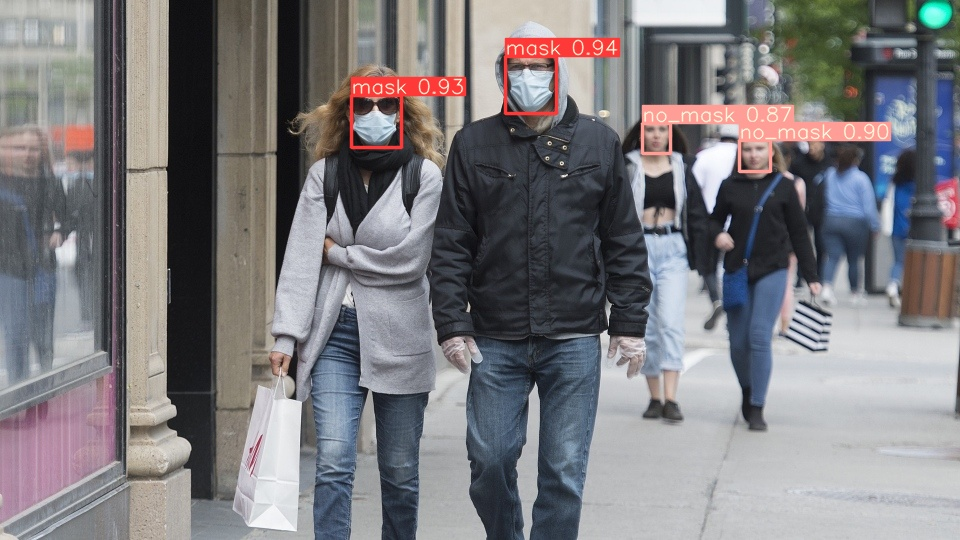

In [ ]:
Image('/kaggle/working/yolov5/runs/detect/exp/image.jpg')